# Welcome to this jupyter notebool
**The goal of this work is to fine the better location for a new wine bar or shop.**
1. In order to do so, we'll look at each *arrondissement* (subdivisions of frenchs' cities) and extract all the venues in them
2. We'll pick the one that does not have a lot of restaurants or wine bar/shop but not none (we need a *arrondissement* that is living).
3. After selecting one, we need to identify cluster of venues - venues are usually not alone
4. Identify the better cluster which would be a good location to set a wine bar/shop

## 1 - Get all the venues in each *arrondissement*

First, let's load our packages

In [54]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
import pandas as pd
import requests
from bs4 import BeautifulSoup
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Each wikipedia url for each twenty *arrondissement* are the same format, which make it easy to loop in

In [2]:
arr = ['1er','2e','3e','4e','5e','6e','7e','8e','9e','10e','11e','12e','13e','14e','15e','16e','17e','18e','19e','20e']
url = list()
for i in range(20):
    url.append('https://fr.wikipedia.org/wiki/' + arr[i] + '_arrondissement_de_Paris')

In [3]:
def get_info_arr(url):
    # Load html data and looking for the table
    html_data = requests.get(url).text   
    soup = BeautifulSoup(html_data,"html5lib") 
    coor = soup.find('table')
    df = pd.read_html(str(coor))[0]    
    # Get coord
    coord = df.loc[df[0] == 'Coordonnées'][1]
    # Latitude coord
    latitude = float(coord.to_string().split()[1][0:2]) + float(coord.to_string().split()[2][0:2])/60 + float(coord.to_string().split()[3][0:2])/3600
    # Longitude coord
    longitude = float(coord.to_string().split()[5][0:1]) + float(coord.to_string().split()[6][0:2])/60 + float(coord.to_string().split()[7][0:2])/3600
    # Population
    pop = df.loc[df[0] == 'Population'][1]
    population = int(pop.to_string().split()[1]) * 1000 + int(pop.to_string().split()[2])
    # return the correct infos
    return latitude, longitude, population

We get the latitude (`lat`), longitude (`lon`) and population (`pop`) from the wikipedia pages.

In [4]:
lat = [0 for i in range(20)]
lon = [0 for i in range(20)]
pop = [0 for i in range(20)]
i = 0
for u in url:
    [lat[i], lon[i], pop[i]] = get_info_arr(u)
    i = i + 1

#### We can now create our data frame (`df`) which contains the lattitude, longitude and the population for each *arrondissement*.

In [5]:
df = pd.DataFrame({'Arr':[i+1 for i in range(20)],'Latitude':lat,'Longitude':lon,'Population':pop})
df.index = np.arange(1, len(df) + 1)
df

,Arr,Latitude,Longitude,Population
1,1,48.860000,2.341944,16395
2,2,48.866944,2.340556,21042
3,3,48.863889,2.361667,34389
4,4,48.856111,2.355556,28370
5,5,48.846111,2.344722,59631
6,6,48.850556,2.332778,41976
7,7,48.856944,2.320000,52193
8,8,48.877778,2.317778,37368
9,9,48.872500,2.340278,60071
10,10,48.871944,2.357500,90836


#### Now let's get all the venues from the FourSquare API

In [6]:
CLIENT_ID = '---' # your Foursquare ID
CLIENT_SECRET = '---' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 1000 # A default Foursquare API limit value

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Arr', 
                  'Arr Latitude', 
                  'Arr Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue id']
    
    return(nearby_venues)

#### Let's note that the radius was set quite high in order to not miss any venues. However, duplicates will likely be created, so we'll drop them using the venues name.

In [9]:
df_venues = getNearbyVenues(names=df.Arr, latitudes=df['Latitude'], longitudes=df['Longitude']).drop_duplicates(subset='Venue')
df_venues.head()

,Arr,Arr Latitude,Arr Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue id
0,1,48.86,2.341944,Place du Louvre,48.859841,2.340822,Plaza,4f979c8ae4b05465dae0714f
1,1,48.86,2.341944,Cour Carrée du Louvre,48.860360,2.338543,Pedestrian Plaza,4c079d740ed3c928b6be797d
2,1,48.86,2.341944,Église Saint-Germain-l'Auxerrois (Église Saint...,48.859520,2.341306,Church,4adcda09f964a520173421e3
3,1,48.86,2.341944,Boutique yam'Tcha,48.861710,2.342380,Chinese Restaurant,548884fc498e7a7ca55edf84
4,1,48.86,2.341944,La Vénus de Milo (Vénus de Milo),48.859943,2.337234,Exhibit,5864efb745c3ed1e7d88e96d


#### Let's extract a dataframe for each *Restaurant* type, as well as a *Wine* dataframe.

In [10]:
df_rest = df_venues[df_venues['Venue Category'].str.contains('Restaurant')]
df_wine = df_venues[df_venues['Venue Category'].str.contains('Wine')]
df_wine.head()

,Arr,Arr Latitude,Arr Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue id
10,1,48.860000,2.341944,Chez Nous,48.855823,2.340271,Wine Bar,53568d3e498e92e5a3a56f36
56,1,48.860000,2.341944,L'Avant Comptoir,48.852039,2.338813,Wine Bar,4afd8300f964a5203a2822e3
84,1,48.860000,2.341944,Compagnie des Vins Surnaturels,48.851740,2.336406,Wine Bar,4e67b1d8fa76f38efb3aaa09
181,2,48.866944,2.340556,Le Bouclier de Bacchus,48.876834,2.337843,Wine Bar,4e738c6245dd41e9ccfca245
204,3,48.863889,2.361667,Le Barav,48.865166,2.363155,Wine Bar,4b68a117f964a520c8832be3


#### Let's now create a bigger dataframe that have the number of restaurants, wine bars and shops, but also the number of restaurants and wine bars and shops for 1000 residents. A small *arrondissement* with a (relatively) small number of restaurants is not representative.

In [13]:
df_rest_count = df_rest['Arr'].value_counts().to_frame().sort_index(ascending=True).rename(columns={'Arr':'# of Restaurants'})
df_wine_count = df_wine['Arr'].value_counts().to_frame().sort_index(ascending=True).rename(columns={'Arr':'# of Wine Bar/Shop'})

df_stat = df_rest_count.join(df_wine_count).replace(np.nan, 0)
df_stat['# Restaurant per 1000 residents'] = df_stat['# of Restaurants'] / (df['Population'] / 1000)
df_stat['# Wine Bar/Shop per 1000 residents'] = df_stat['# of Wine Bar/Shop'] / (df['Population'] / 1000)

df_stat.sort_values(by=['# of Restaurants'])

,# of Restaurants,# of Wine Bar/Shop,# Restaurant per 1000 residents,# Wine Bar/Shop per 1000 residents
10,6,0.0,0.066053,0.000000
2,6,1.0,0.285144,0.047524
4,6,2.0,0.211491,0.070497
6,7,0.0,0.166762,0.000000
7,8,0.0,0.153277,0.000000
9,8,2.0,0.133176,0.033294
5,11,1.0,0.184468,0.016770
12,15,0.0,0.106167,0.000000
18,17,0.0,0.086677,0.000000
1,18,3.0,1.097896,0.182983


#### Let's plot as histograms to better see which *arrondissement* pick.

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


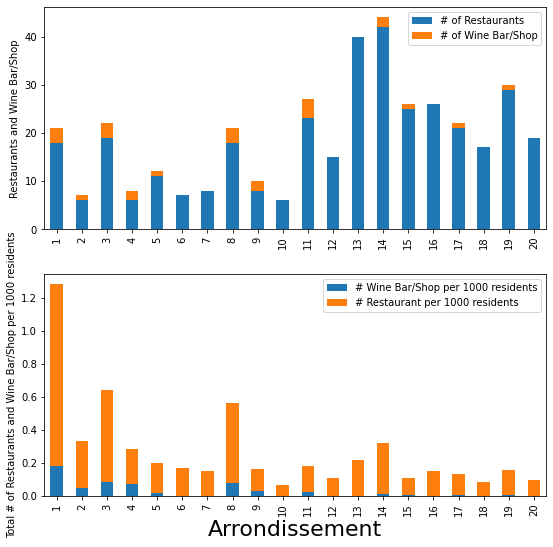

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1)
df_stat.plot.bar(ax=axes[0],y={'# of Restaurants','# of Wine Bar/Shop'},stacked=True,figsize=(9,9))
axes[0].set_xlabel('',FontSize=22);
axes[0].set_ylabel('Restaurants and Wine Bar/Shop',FontSize=10);
###
df_stat.plot.bar(ax=axes[1], y={'# Restaurant per 1000 residents','# Wine Bar/Shop per 1000 residents'},stacked=True,figsize=(9,9))
axes[1].set_xlabel('Arrondissement',FontSize=22);
axes[1].set_ylabel('Total # of Restaurants and Wine Bar/Shop per 1000 residents',FontSize=10);

## 2 - Choose third arrondissement
* Already existing restaurants and wine bar/shop but not much
* Low number of restaurant et wine bar/shop per 1000 residents

### Next step is to find all venus from the third *arrondissement*
* At the coordinate of the third *arrondissement* look from venues in a big circle (regular calls)
* Loop on every id venues to have their location (premium calls)
* Clean data : third arrondissement have a postal code of 75003 and neighbourhood *arrondissement*

In [15]:
df_third = df_venues.loc[df_venues['Arr']==3]
df_third.shape

(65, 8)

In [16]:
def getVenuePostalCode(venue_id):            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
    # make the GET request
    results = requests.get(url).json()["response"]
    # Get the postal code
    try:
        postal_code = int(results['venue']['location']['postalCode'])
    except:
        postal_code = 75000
    return postal_code

In [17]:
postal_code = []
i = 0
for id in df_third['Venue id']:
    postal_code.append(getVenuePostalCode(id))
    i = i + 1

In [18]:
df_third['Postal Code'] = postal_code

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### We won't only keep  the 3rd Arrondissement, it's a small one. We'll also use the 1st, 2nd, 4th, 10th and 11th, which are all around the third.

In [19]:
df_third = df_third[(df_third['Postal Code']==75003) | (df_third['Postal Code']==75001) | (df_third['Postal Code']==75002) | (df_third['Postal Code']==75004) | (df_third['Postal Code']==75010) | (df_third['Postal Code']==75011)] 
df_third

,Arr,Arr Latitude,Arr Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue id,Postal Code
200,3,48.863889,2.361667,Mmmozza,48.863910,2.360591,Sandwich Place,4d974096a2c654814aa6d353,75003
201,3,48.863889,2.361667,Chez Alain Miam Miam,48.862369,2.361950,Sandwich Place,5b546a4a82a750002c940e7f,75003
202,3,48.863889,2.361667,Marché des Enfants Rouges,48.862806,2.361996,Farmers Market,4b75734cf964a5202c0d2ee3,75003
203,3,48.863889,2.361667,Candelaria,48.863032,2.364059,Cocktail Bar,4d77b39caf63cbff3997be0f,75003
204,3,48.863889,2.361667,Le Barav,48.865166,2.363155,Wine Bar,4b68a117f964a520c8832be3,75003
205,3,48.863889,2.361667,Square du Temple,48.864475,2.360816,Park,4b93cba4f964a520155234e3,75003
206,3,48.863889,2.361667,L'Îlot,48.864666,2.363317,Seafood Restaurant,501ab9cfe4b089ae3961a041,75004
207,3,48.863889,2.361667,Monoprix,48.866150,2.361548,Supermarket,4af5aeaaf964a5203cfb21e3,75003
208,3,48.863889,2.361667,Fermier Gourmet,48.865489,2.360465,Steakhouse,57b7049f498e2dc8c090a235,75003
209,3,48.863889,2.361667,Le Mary Céleste,48.861742,2.365012,Cocktail Bar,5116b70ce4b0d096ad258d22,75004


## 3 -  Check position of all the venues
* Display map of the retained venues
* Then we'll cluster using **k-means** the venues to try pin point a stop with respect of existing venues in a smaller area

In [26]:
map_third = folium.Map(location=[48.8672222222, 2.36666666667], zoom_start=15)

# add markers to map
for lat, lng, ven_cat in zip(df_third['Venue Latitude'], df_third['Venue Longitude'], df_third['Venue Category']):
    #label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(ven_cat, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_third)  
    
map_third

#### We can see 4 clusters on the map, let's clustering them to identify the style of each cluster

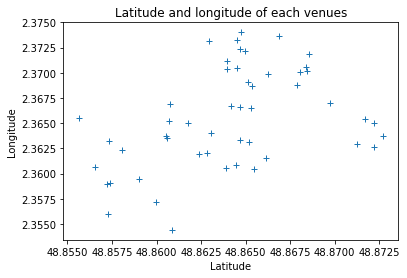

In [43]:
# data
lat = np.array(df_third['Venue Latitude']);
lon = np.array(df_third['Venue Longitude']);
plt.plot(lat,lon,'+');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
plt.title('Latitude and longitude of each venues');

In [28]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(np.vstack((lat, lon)).T)

In [29]:
colors_map = np.array(['blue', 'red','black','green'])
colors_label = colors_map[kmeans.labels_]

#### Let's look at the of all the venues retained and attribute them a color for their clusters.

In [30]:
map_third_cluster = folium.Map(location=[48.8672222222, 2.36666666667], zoom_start=15)

# add markers to map
i = 0
for lat, lng, ven_cat in zip(df_third['Venue Latitude'], df_third['Venue Longitude'], df_third['Venue Category']):
    #label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(ven_cat, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors_label[i],
        fill=True,
        fill_color=colors_label[i],
        fill_opacity=0.7,
        parse_html=False).add_to(map_third_cluster)  
    i = i + 1
    
map_third_cluster

#### There is in fact four clusters, which by looking at the map make sense.

In [44]:
df_third['Cluster Label'] = kmeans.labels_
df_third.tail()

,Arr,Arr Latitude,Arr Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue id,Postal Code,Cluster Label
271,3,48.863889,2.361667,Galerie Sakura,48.857264,2.356032,Art Gallery,536e2e04498e18340911a3c7,75004,1
272,3,48.863889,2.361667,SAaM,48.872177,2.362684,Korean Restaurant,556a1b6f498e6c30a65b74b6,75010,0
273,3,48.863889,2.361667,Siseng,48.872217,2.365049,Asian Restaurant,548ecb1b498eecad73397311,75010,0
274,3,48.863889,2.361667,Tannat,48.868529,2.371895,Restaurant,551ef03f498eb4cd7989ff19,75011,2
275,3,48.863889,2.361667,Café Oberkampf,48.864715,2.374020,Coffee Shop,55c45a89498e331c0892f410,75011,2


## 4 - Let's group by label to identify each cluster type of venues
Then we'll identify the best cluster that is a neighbourhood with restaurants.

In [32]:
# one hot encoding
third_cat_to_ind = pd.get_dummies(df_third[['Venue Category']], prefix="", prefix_sep="")

# add Cluster Label column back to dataframe
third_cat_to_ind['Cluster Label'] = df_third['Cluster Label'] 

# move Cluster Label column to the first column
fixed_columns = [third_cat_to_ind.columns[-1]] + list(third_cat_to_ind.columns[:-1])
third_cat_to_ind = third_cat_to_ind[fixed_columns]

# Let's group
df_third_grouped = third_cat_to_ind.groupby('Cluster Label').mean().reset_index()
df_third_grouped

,Cluster Label,Art Gallery,Asian Restaurant,Bakery,Bookstore,Breakfast Spot,Burger Joint,Canal,Cheese Shop,Clothing Store,...,Restaurant,Sandwich Place,Seafood Restaurant,Speakeasy,Steakhouse,Supermarket,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,0,0.000000,0.166667,0.166667,0.166667,0.000000,0.0,0.166667,0.166667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.100000,0.000000,0.000000,0.000000,0.000000,0.1,0.000000,0.000000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.000000,0.000000,0.117647,0.058824,0.000000,0.0,0.000000,0.000000,0.000000,...,0.176471,0.000000,0.000000,0.058824,0.000000,0.000000,0.058824,0.058824,0.000000,0.058824
3,3,0.176471,0.000000,0.000000,0.000000,0.058824,0.0,0.000000,0.000000,0.058824,...,0.000000,0.117647,0.058824,0.000000,0.058824,0.058824,0.000000,0.000000,0.058824,0.058824


#### Let's look at the top 5 venue type of each cluster

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Label']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_third_grouped_sorted = pd.DataFrame(columns=columns)
df_third_grouped_sorted['Cluster Label'] = df_third_grouped['Cluster Label']

for ind in np.arange(df_third_grouped.shape[0]):
    df_third_grouped_sorted.iloc[ind, 1:] = return_most_common_venues(df_third_grouped.iloc[ind, :], num_top_venues)

df_third_grouped_sorted.head()

,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Bakery,Bookstore,Asian Restaurant,Canal,Cheese Shop
1,1,Clothing Store,Art Gallery,Plaza,Israeli Restaurant,Falafel Restaurant
2,2,French Restaurant,Restaurant,Italian Restaurant,Bakery,Wine Bar
3,3,Art Gallery,Sandwich Place,Cocktail Bar,Coffee Shop,Vietnamese Restaurant


#### A wine bar or shop would fit perfectly on the cluster 2 with restaurants already in place
Let's look at the map and create a circle around the second cluster center.

In [53]:
map_third_perfect_cluster = folium.Map(location=[kmeans.cluster_centers_[2][0], kmeans.cluster_centers_[2][1]], zoom_start=15)
label = folium.Popup(ven_cat, parse_html=True)
folium.CircleMarker(
    [kmeans.cluster_centers_[2][0], kmeans.cluster_centers_[2][1]],
        radius=70,
        popup='Perfect stop',
        color='red',
        fill=True,
        fill_color='#3186cc',
        parse_html=False).add_to(map_third_perfect_cluster)  

    
map_third_perfect_cluster